# 📈 Integrated Dividend Feature Analysis

This notebook combines visual correlation analysis, regression diagnostics, and model-based feature importance to analyze the impact of various features on dividend-related metrics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# --- Configuration & robust loading ---
import os, glob
import pandas as pd
import numpy as np

# 1) Load all ticker time-series
history_files = glob.glob("../features_data/tickers_history/*.parquet")
if not history_files:
    raise FileNotFoundError("No parquet files under features_data/tickers_history/")
df_features = pd.concat([pd.read_parquet(f) for f in history_files], ignore_index=True)

# 2) Load static raw + OHE (handle older files without raw labels)
static_path = "../features_data/tickers_static/static_ticker_info.parquet"
if not os.path.exists(static_path):
    raise FileNotFoundError(static_path)
df_static_raw = pd.read_parquet(static_path)

ohe_path = "../features_data/tickers_static/static_ohe.parquet"
if os.path.exists(ohe_path):
    df_static_ohe = pd.read_parquet(ohe_path)
else:
    # fallback: pick OHE cols from raw file
    df_static_ohe = df_static_raw.filter(regex=r"^ticker$|^(sector_|country_)")

def _infer_label_from_ohe(df, prefix: str) -> pd.Series:
    """Infer human label from OHE columns; returns NaN if none present."""
    ohe_cols = [c for c in df.columns if c.startswith(prefix + "_") and c != f"{prefix}_other"]
    if not ohe_cols:
        return pd.Series(np.nan, index=df.index)
    idx = df[ohe_cols].idxmax(axis=1)
    lab = (
        idx.str.replace(f"{prefix}_", "", regex=False)
           .str.replace("_", " ")
           .str.title()
           .replace({"Usa": "USA", "Uk": "UK", "Uae": "UAE"})
    )
    return lab

# Build raw labels (ticker + country/sector if present; else infer from OHE)
raw_cols = [c for c in ["ticker", "country", "sector"] if c in df_static_raw.columns]
raw_labels = df_static_raw[raw_cols].copy() if raw_cols else df_static_ohe[["ticker"]].copy()

if "sector" not in raw_labels.columns:
    raw_labels["sector"] = _infer_label_from_ohe(df_static_ohe, "sector")
if "country" not in raw_labels.columns:
    raw_labels["country"] = _infer_label_from_ohe(df_static_ohe, "country")

# Merge labels + OHE; only select columns that exist
ohe_cols = [c for c in df_static_ohe.columns if c != "ticker"]
df_static = raw_labels.merge(df_static_ohe, on="ticker", how="left")
keep_cols = ["ticker"] + [c for c in ["country", "sector"] if c in df_static.columns] + ohe_cols

df_features = df_features.merge(df_static[keep_cols], on="ticker", how="left")

# 3) Normalize countries for macro join
COUNTRY_NORMALIZATION = {
    "USA": "United States",
    "UK": "United Kingdom",
    "UAE": "United Arab Emirates",
    "Korea": "South Korea",
    "Republic of Korea": "South Korea",
    "Czechia": "Czech Republic",
    "Russian Federation": "Russia",
    "Hong Kong": "Hong Kong SAR",
}

if "country" not in df_features.columns:
    df_features["country"] = np.nan

# create normalized country column
df_features["country_norm"] = (
    df_features["country"]
    .replace(COUNTRY_NORMALIZATION)
    .astype(object)
)



# 4) Load ALL macro files and concat
macro_files = glob.glob("../features_data/macro_history/*.parquet")
if not macro_files:
    print("⚠️ No macro files found under features_data/macro_history/. Macro merge will be empty.")
    df_macro_all = pd.DataFrame(columns=["as_of_year", "country"])
else:
    df_macro_all = pd.concat([pd.read_parquet(f) for f in macro_files], ignore_index=True)

df_macro_all["country"] = df_macro_all["country"].astype(object)
# 5) Year alignment
df_features["as_of"] = pd.to_datetime(df_features["as_of"])
df_features["as_of_year"] = df_features["as_of"].dt.year.astype("Int64")
if "as_of_year" in df_macro_all.columns and not pd.api.types.is_integer_dtype(df_macro_all["as_of_year"]):
    df_macro_all["as_of_year"] = df_macro_all["as_of_year"].astype("Int64")

# 6) Merge features+static with macro on (year, normalized country)
df_merged = df_features.merge(
    df_macro_all,
    left_on=["as_of_year", "country_norm"],
    right_on=["as_of_year", "country"],
    how="left",
    suffixes=("", "_macro"),
)

# Ensure OHEs are numeric 0/1 floats
for col in [c for c in df_merged.columns if c.startswith("sector_") or c.startswith("country_")]:
    df_merged[col] = pd.to_numeric(df_merged[col], errors="coerce").fillna(0.0).astype(np.float32)

# Cleanups & quick checks
for col in ("backfilled_year",):
    if col in df_merged.columns:
        df_merged.drop(columns=[col], inplace=True)

print("Data loaded and merged successfully.")
print("df_features country (raw) unique:", sorted(df_features["country"].dropna().unique().tolist()))
print("df_features country_norm unique:", sorted(df_features["country_norm"].dropna().unique().tolist()))
print("macro countries:", sorted(df_macro_all["country"].dropna().unique().tolist()) if "country" in df_macro_all.columns else "N/A")
print("Merge macro coverage (non-null gdp_yoy_backfilled):", df_merged.get("gdp_yoy_backfilled").notna().mean() if "gdp_yoy_backfilled" in df_merged.columns else 0.0)


Data loaded and merged successfully.
df_features country (raw) unique: []
df_features country_norm unique: []
macro countries: ['United States']
Merge macro coverage (non-null gdp_yoy_backfilled): 0.0


In [3]:
DIVIDEND_FEATURES = [
    "dividend_yield",
    "dividend_cagr_3y",
    "dividend_cagr_5y",
    "yield_vs_5y_median",
]

SECTOR_COLS = sorted([c for c in df_merged.columns if c.startswith("sector_") and c != "sector_relative_6m"])
COUNTRY_COLS = sorted([c for c in df_merged.columns if c.startswith("country_")])
HAS_COLS = sorted([c for c in df_merged.columns if c.startswith("has_")])

BINARY_FEATURES = SECTOR_COLS + COUNTRY_COLS + HAS_COLS
EXCLUDE_FEATURES = ["ticker", "as_of", "as_of_year", "country", "country_norm", "sector"] + DIVIDEND_FEATURES

all_columns = df_merged.columns.tolist()
independent_features = [col for col in all_columns if col not in EXCLUDE_FEATURES]
numerical_independent_features = [f for f in independent_features if f not in BINARY_FEATURES]
categorical_independent_features = [f for f in independent_features if f in BINARY_FEATURES]


In [4]:
predictor_categories = {
    "Financial_Metrics": [
        f for f in numerical_independent_features
        if any(k in f for k in ("return", "ratio", "cagr", "cover", "volatility", "drawdown"))
    ],
    "Macro_Economic": [
        col for col in ["gdp_yoy_backfilled", "inflation_latest", "unemployment_latest", "consumption_backfilled"]
        if col in df_merged.columns
    ],
    "Sector_OHE": SECTOR_COLS,
    "Country_OHE": COUNTRY_COLS,
}
predictor_categories


{'Financial_Metrics': ['6m_return',
  '12m_return',
  'volatility',
  'max_drawdown_1y',
  'ebit_interest_cover',
  'ebit_interest_cover_capped',
  'eps_cagr_3y',
  'fcf_cagr_3y',
  'pe_ratio',
  'pfcf_ratio',
  'payout_ratio'],
 'Macro_Economic': ['gdp_yoy_backfilled',
  'inflation_latest',
  'unemployment_latest',
  'consumption_backfilled'],
 'Sector_OHE': [],
 'Country_OHE': ['country_macro', 'country_norm']}

In [5]:
predictor_categories

{'Financial_Metrics': ['6m_return',
  '12m_return',
  'volatility',
  'max_drawdown_1y',
  'ebit_interest_cover',
  'ebit_interest_cover_capped',
  'eps_cagr_3y',
  'fcf_cagr_3y',
  'pe_ratio',
  'pfcf_ratio',
  'payout_ratio'],
 'Macro_Economic': ['gdp_yoy_backfilled',
  'inflation_latest',
  'unemployment_latest',
  'consumption_backfilled'],
 'Sector_OHE': [],
 'Country_OHE': ['country_macro', 'country_norm']}

In [6]:
def plot_scatter_regression(df, target_feature, numerical_features):
    for feature in numerical_features:
        if (
            feature in df.columns
            and df[feature].notna().sum() >= 3
            and df[feature].nunique() > 2
            and not feature.endswith('_capped')
            and not feature.startswith('has_')
        ):
            plt.figure(figsize=(7, 4))
            sns.scatterplot(x=feature, y=target_feature, data=df, alpha=0.6)
            sns.regplot(x=feature, y=target_feature, data=df, scatter=False, color='red', line_kws={'alpha': 0.6})
            plt.title(f'{target_feature} vs. {feature}')
            plt.tight_layout()
            plt.show()

def plot_sector_boxplot(df, target_feature):
    sector_cols = [f for f in df.columns if f.startswith("sector_") and f != "sector_relative_6m"]
    if not sector_cols:
        return df
    tmp = df.copy()
    tmp["sector_label"] = (
        tmp[sector_cols].idxmax(axis=1)
            .str.replace("^sector_", "", regex=True)
            .str.replace("_", " ").str.title()
    )
    if tmp["sector_label"].nunique() > 1 and tmp[target_feature].notna().sum() >= 5:
        plt.figure(figsize=(10, 5))
        sns.boxplot(x="sector_label", y=target_feature, data=tmp)
        plt.title(f"{target_feature} distribution by sector")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    return df

def plot_binary_categorical_boxplots(df, target_feature, categorical_features):
    for feature in categorical_features:
        if (
            feature in df.columns
            and not feature.startswith('has_')
            and not feature.endswith('_capped')
        ):
            df[feature] = df[feature].astype('category')
            if df[feature].nunique() <= 1:
                continue
            value_counts = df[feature].value_counts(normalize=True)
            if value_counts.iloc[0] > 0.95:
                continue
            plt.figure(figsize=(7, 4))
            sns.boxplot(x=feature, y=target_feature, data=df)
            plt.title(f'{target_feature} distribution by {feature}')
            plt.tight_layout()
            plt.show()

def plot_correlations(df, target_feature, predictor_categories, max_n_plots):
    fig, axes = plt.subplots(1, len(predictor_categories), figsize=(5 * len(predictor_categories), 4))
    if len(predictor_categories) == 1:
        axes = [axes]

    for ax, (group_name, group_features) in zip(axes, predictor_categories.items()):
        valid_feats = [
            f for f in group_features if (
                f in df.columns and 
                df[f].notna().sum() > 2 and 
                not f.startswith('has_') and 
                not f.endswith('_capped') and 
                not f.startswith('sector_')
            )
        ]
        if not valid_feats:
            ax.set_visible(False)
            continue
        data_for_corr = df[valid_feats + [target_feature]].dropna()
        if data_for_corr.shape[0] < 3:
            ax.set_visible(False)
            continue
        corr_vals = data_for_corr.corr()[target_feature].drop(target_feature).dropna()
        corr_vals = corr_vals.sort_values(key=np.abs, ascending=False).head(max_n_plots)
        colors = ['red' if v < 0 else 'blue' for v in corr_vals]
        ax.barh(corr_vals.index.str.replace('_', ' ').str.title(), corr_vals.values, color=colors)
        ax.set_title(f"{group_name} Correlation")
        ax.axvline(0, color='black', lw=0.8)
        ax.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

def plot_random_forest_importance(df, target_feature, predictor_categories, max_n_importance):
    rf_features = [
        f for group in predictor_categories.values() for f in group
        if f in df.columns and not f.endswith('_capped') and not f.startswith('has_')
    ]
    model_data = df[rf_features + [target_feature]].replace([np.inf, -np.inf], np.nan).dropna()
    if len(model_data) < 10 or model_data.shape[1] < 2:
        print("Not enough data for modeling.")
        return
    X = model_data[rf_features]
    y = model_data[target_feature]
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X, y)
    importance_df = (
        pd.DataFrame({"Feature": X.columns, "Importance": rf_model.feature_importances_})
          .sort_values("Importance", ascending=False).head(max_n_importance)
    )
    fig, ax = plt.subplots(figsize=(8, 0.3 * len(importance_df)))
    colors = plt.cm.viridis(np.linspace(0, 1, len(importance_df)))
    bars = ax.barh(range(len(importance_df)), importance_df["Importance"], color=colors)
    ax.set_yticks(range(len(importance_df)))
    ax.set_yticklabels([f.replace('_', ' ').title() for f in importance_df["Feature"]])
    ax.set_xlabel('Feature Importance (Random Forest)')
    ax.set_title(f'Feature Importance for Predicting {target_feature.replace("_", " ").title()}')
    ax.grid(True, alpha=0.3)
    for bar, importance in zip(bars, importance_df["Importance"]):
        ax.text(importance + 0.001, bar.get_y() + bar.get_height() / 2, f'{importance:.3f}', ha='left', va='center', fontsize=8)
    plt.tight_layout(); plt.show()
    print(f"Model R² Score: {r2_score(y, rf_model.predict(X)):.3f}")
    return importance_df



In [14]:
import numpy as np
def analyze_feature_impact(target_feature):
    df_analysis = df_merged[df_merged[target_feature].notna()].copy()
    if df_analysis.empty or df_analysis[target_feature].nunique() <= 1:
        print(f"⚠️ '{target_feature}' has insufficient variation. Skipping.")
        return

    for col in numerical_independent_features:
        df_analysis[col] = pd.to_numeric(df_analysis[col], errors="coerce")


    for f in numerical_independent_features:
        if not np.issubdtype(df_analysis[f].dtype, np.number):
            print(f"⚠️ {f} is {df_analysis[f].dtype} instead of numeric")

    print(f"\n🔍 Analyzing: {target_feature}")
    plot_scatter_regression(df_analysis, target_feature, numerical_independent_features)
    df_analysis = plot_sector_boxplot(df_analysis, target_feature)
    plot_binary_categorical_boxplots(df_analysis, target_feature, categorical_independent_features)
    plot_correlations(df_analysis, target_feature, predictor_categories, max_n_plots=10)
    plot_random_forest_importance(df_analysis, target_feature, predictor_categories, max_n_importance=10)




Analyzing feature: dividend_yield
⚠️ ebit_interest_cover_capped is bool instead of numeric

🔍 Analyzing: dividend_yield


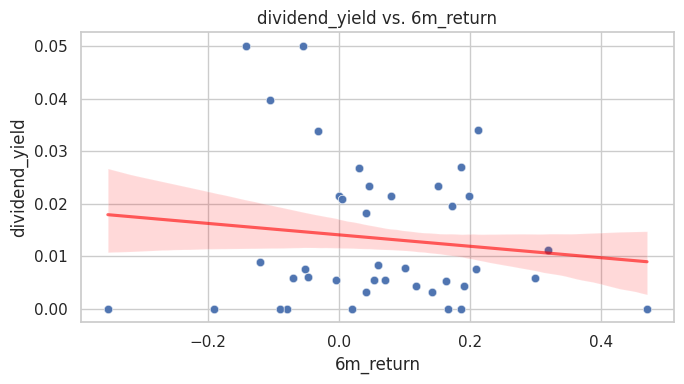

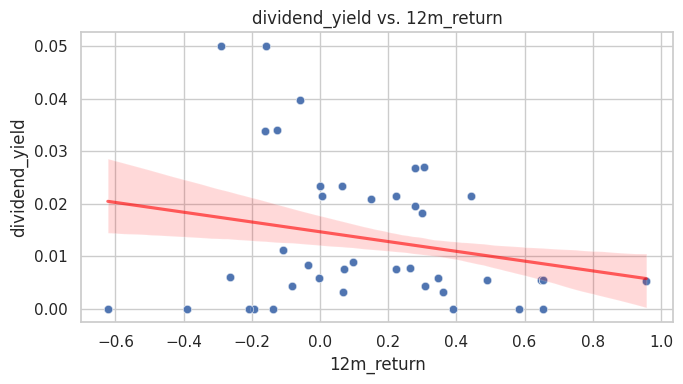

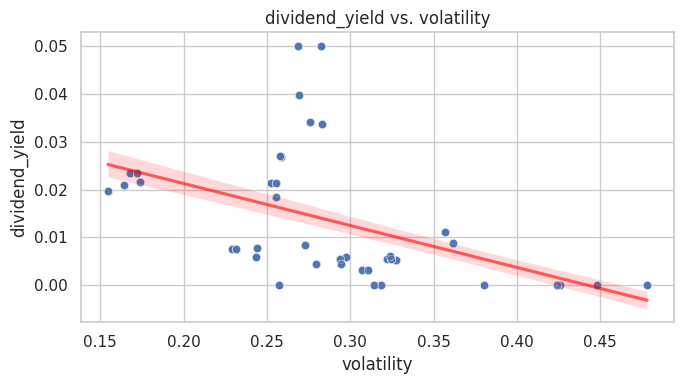

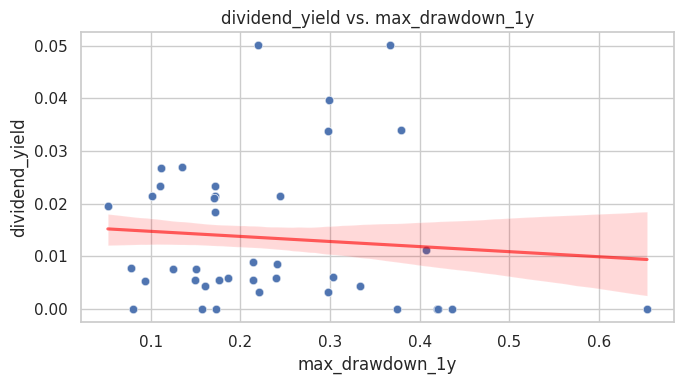

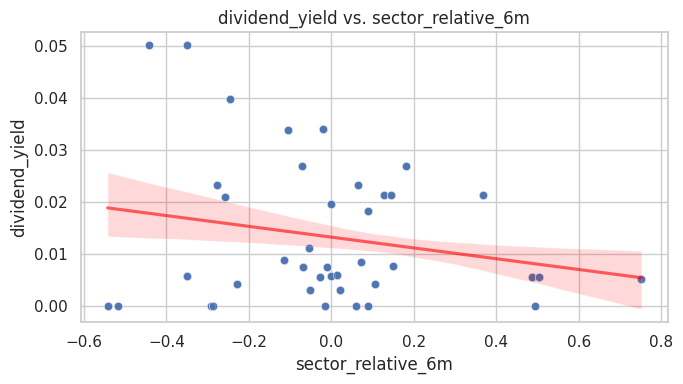

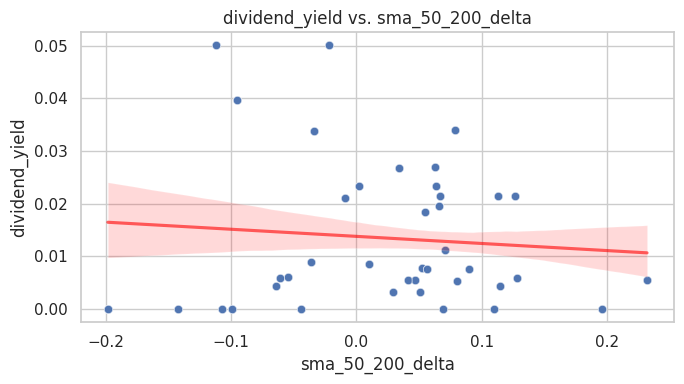

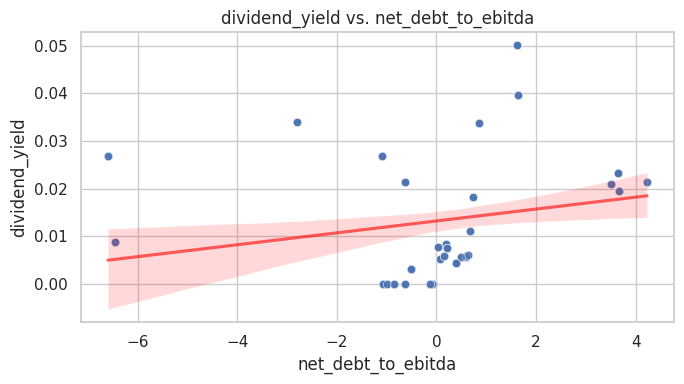

/workspaces/codespaces-blank/dvmax/.venv/lib/python3.12/site-packages/numpy/_core/function_base.py:162: RuntimeWarning: invalid value encountered in multiply
  y *= step
/workspaces/codespaces-blank/dvmax/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


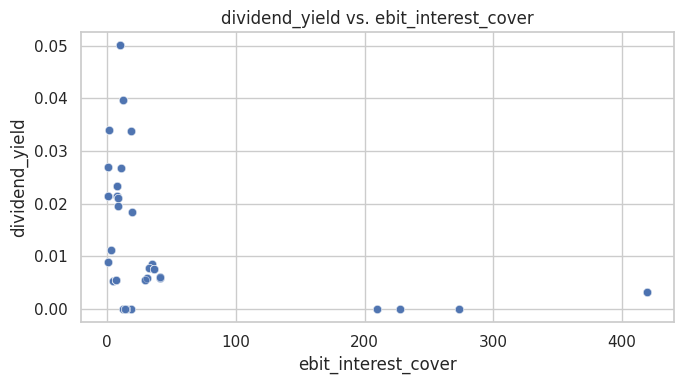

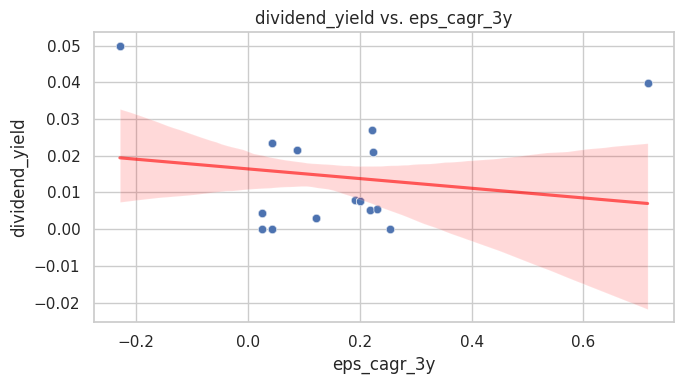

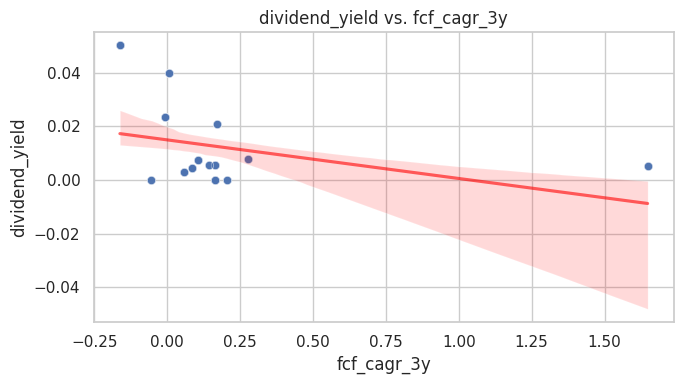

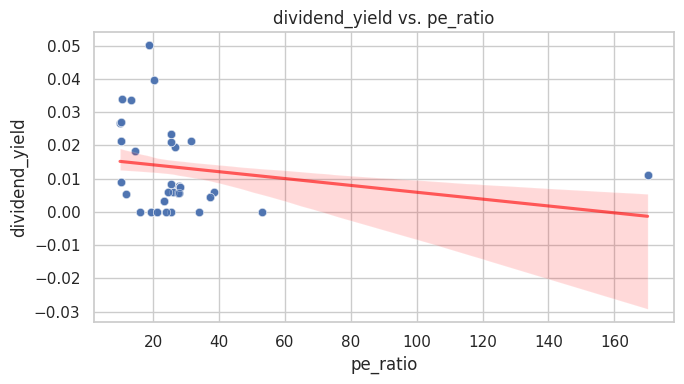

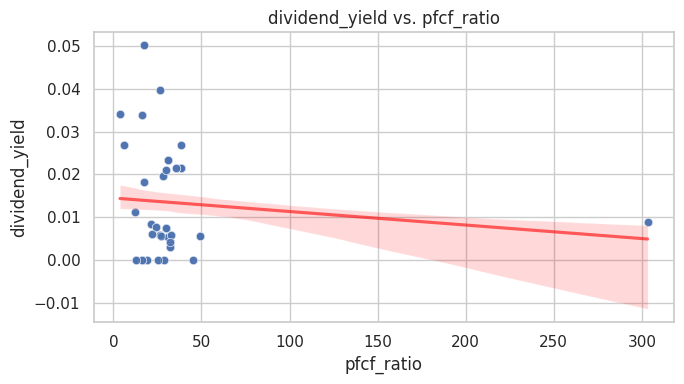

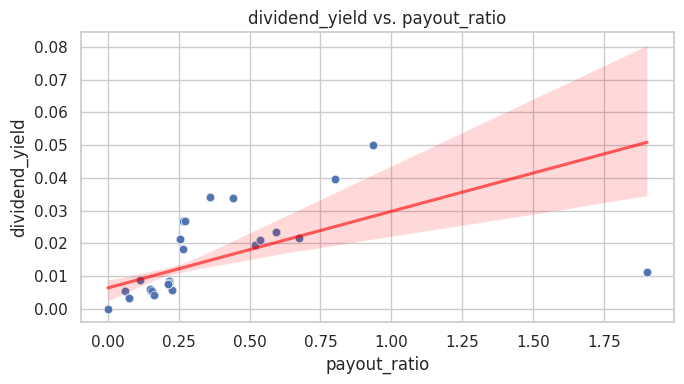

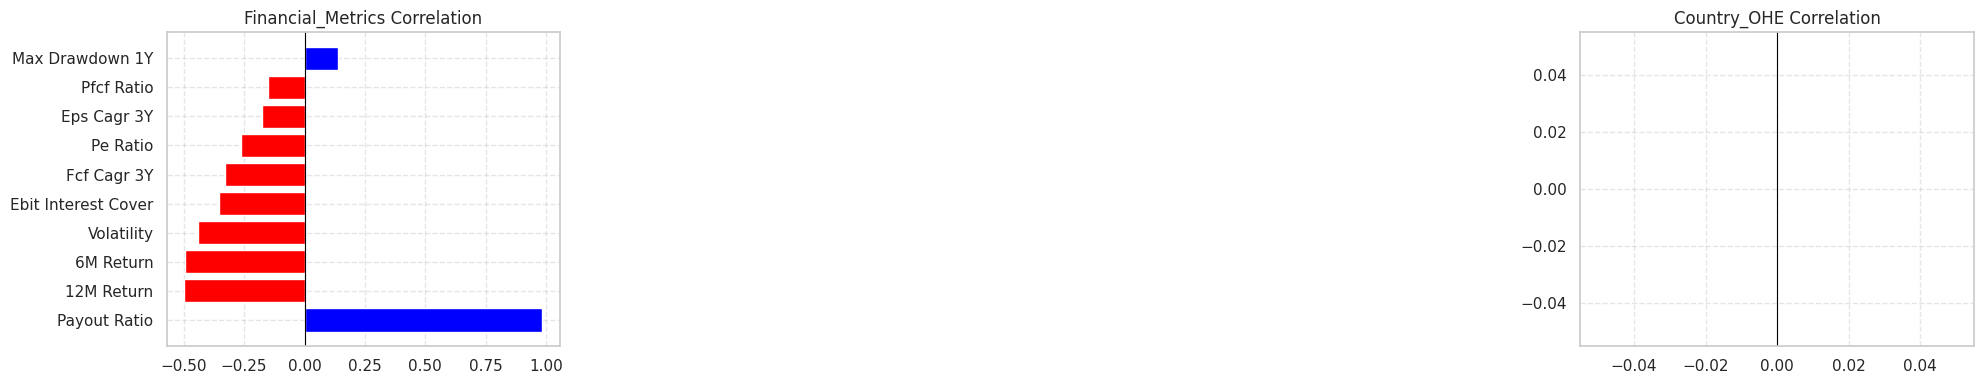

Not enough data for modeling.


Analyzing feature: dividend_cagr_3y
⚠️ ebit_interest_cover_capped is bool instead of numeric

🔍 Analyzing: dividend_cagr_3y


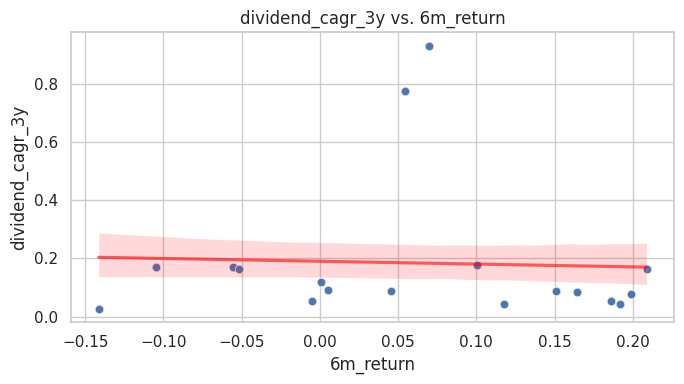

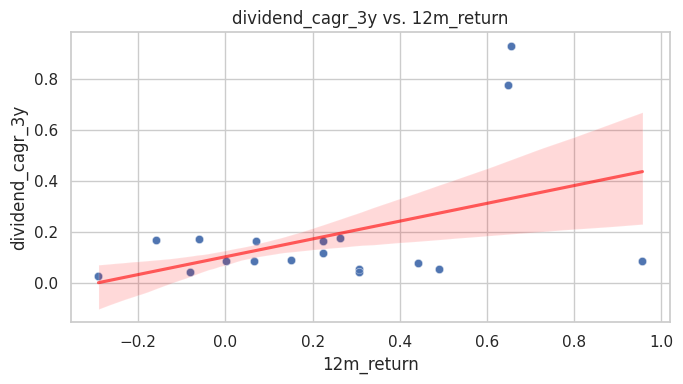

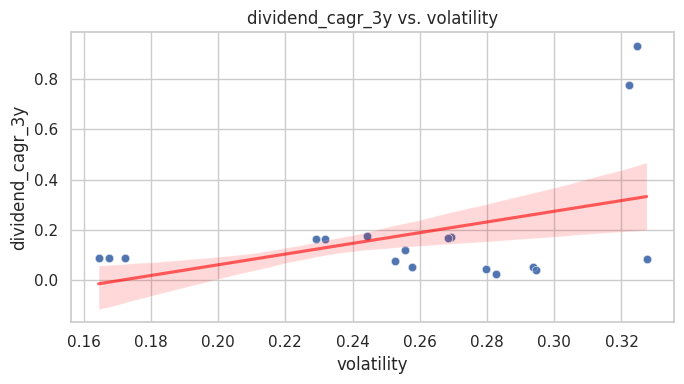

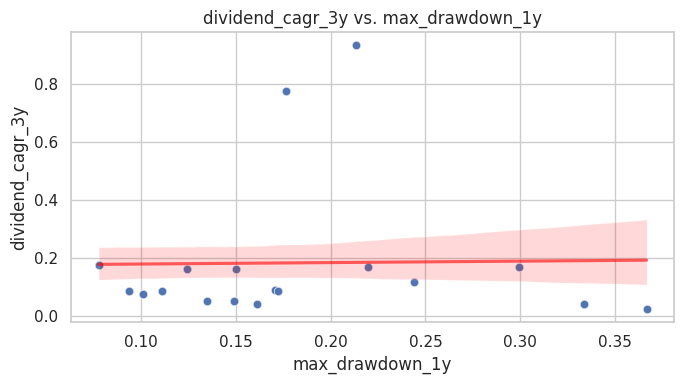

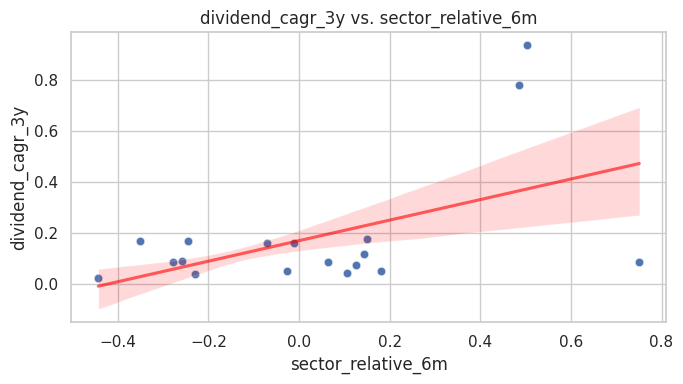

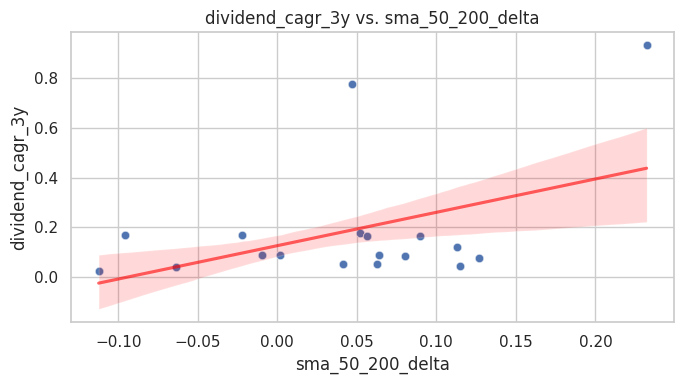

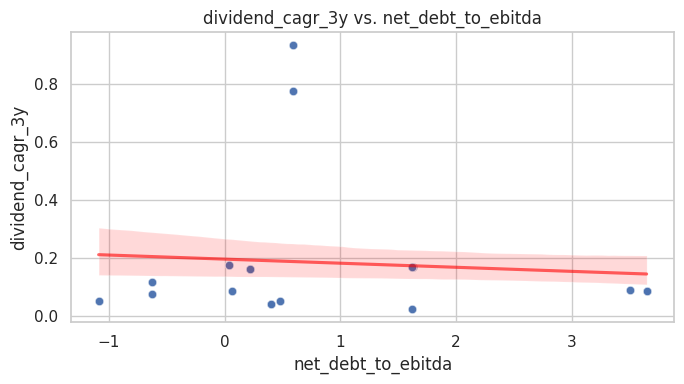

/workspaces/codespaces-blank/dvmax/.venv/lib/python3.12/site-packages/numpy/_core/function_base.py:162: RuntimeWarning: invalid value encountered in multiply
  y *= step
/workspaces/codespaces-blank/dvmax/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


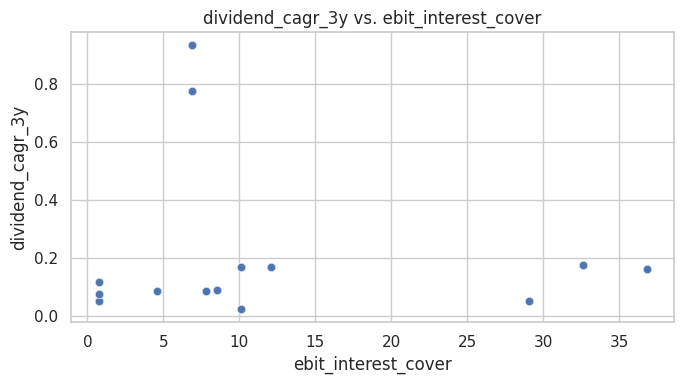

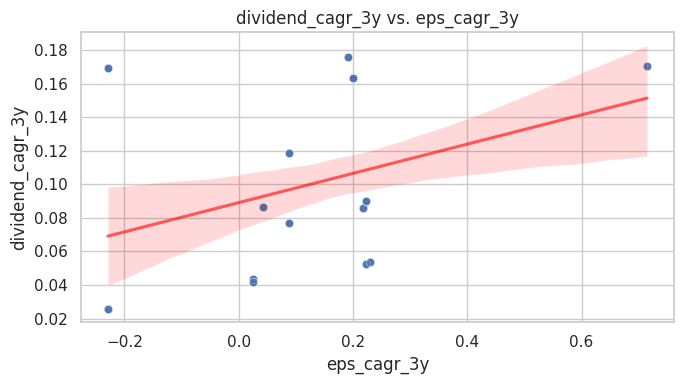

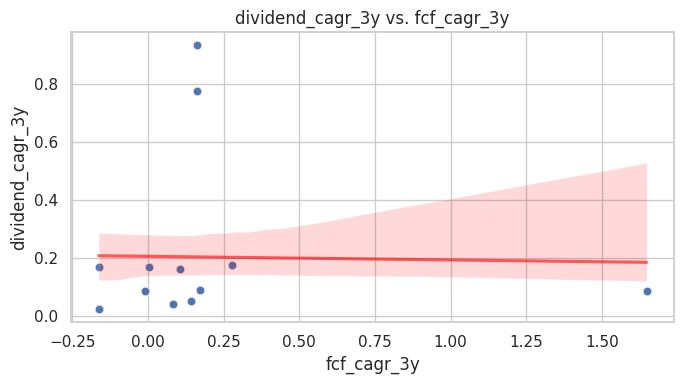

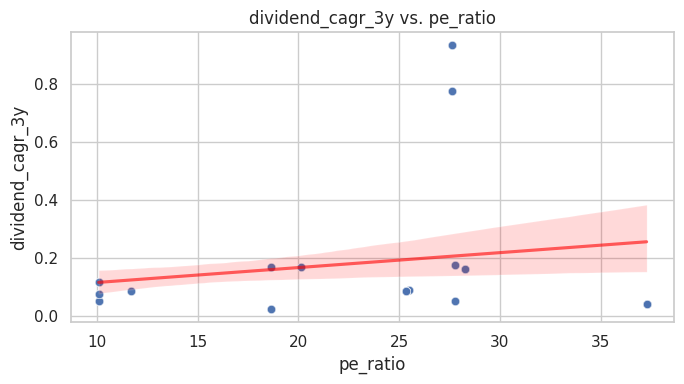

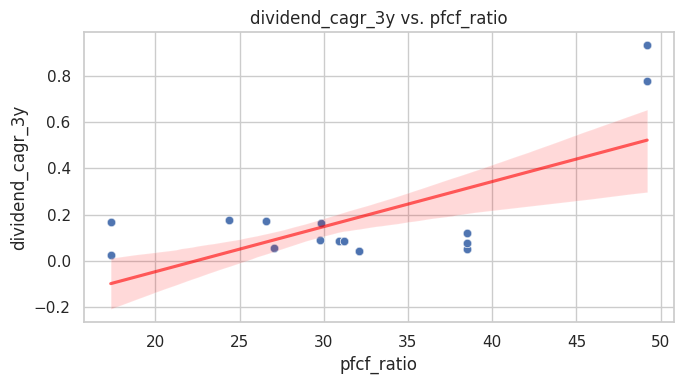

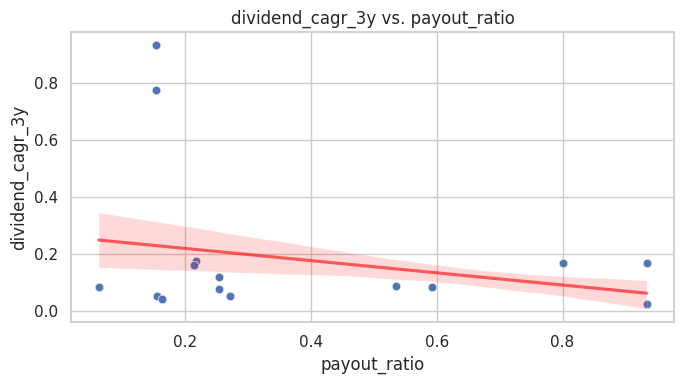

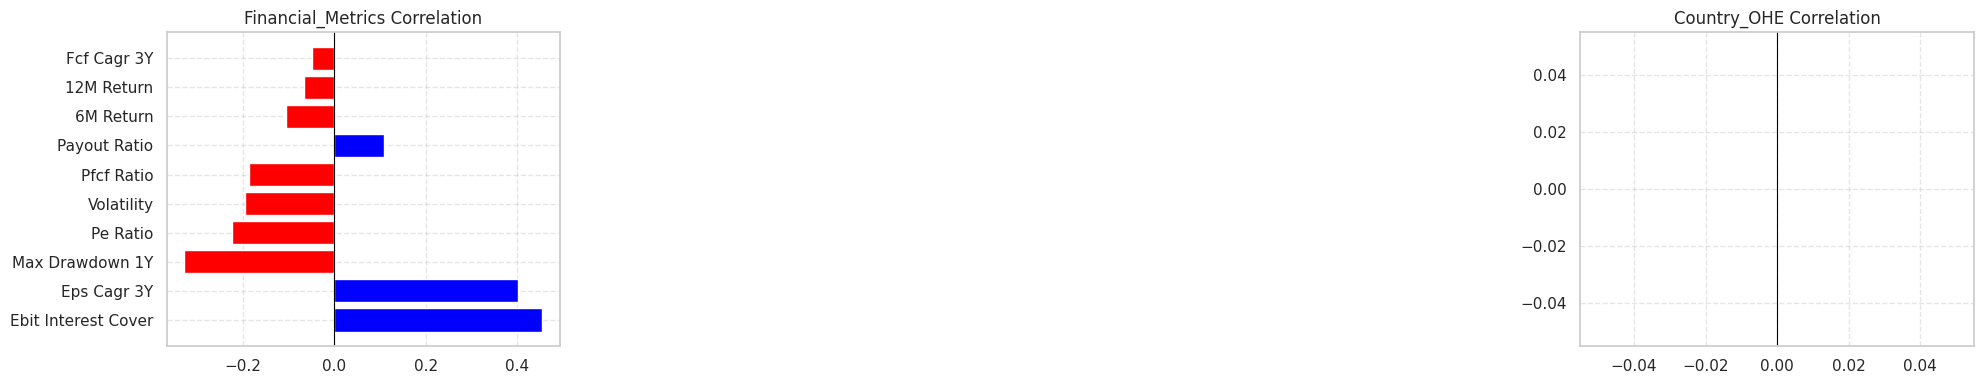

Not enough data for modeling.


Analyzing feature: dividend_cagr_5y
⚠️ ebit_interest_cover_capped is bool instead of numeric

🔍 Analyzing: dividend_cagr_5y


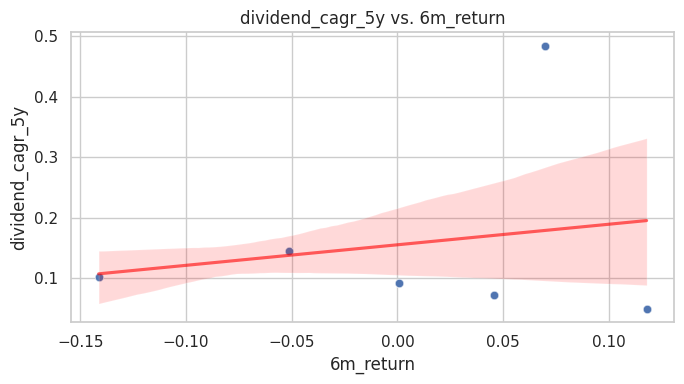

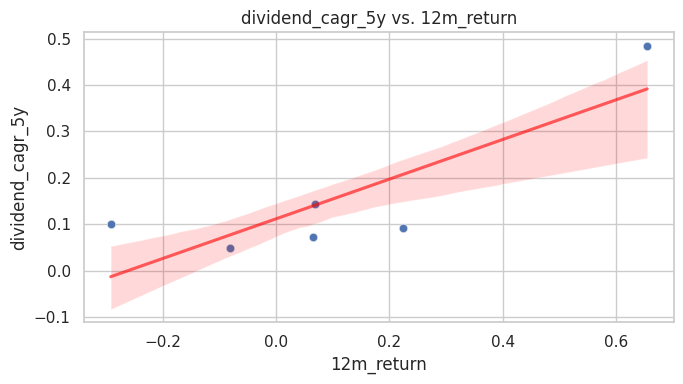

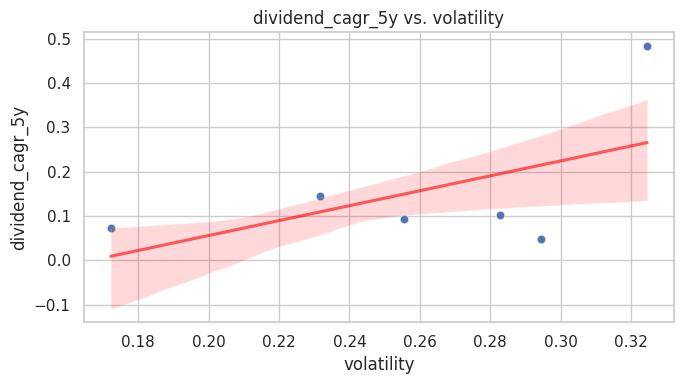

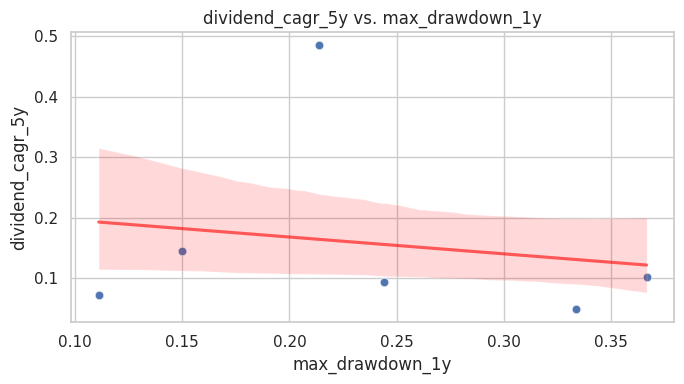

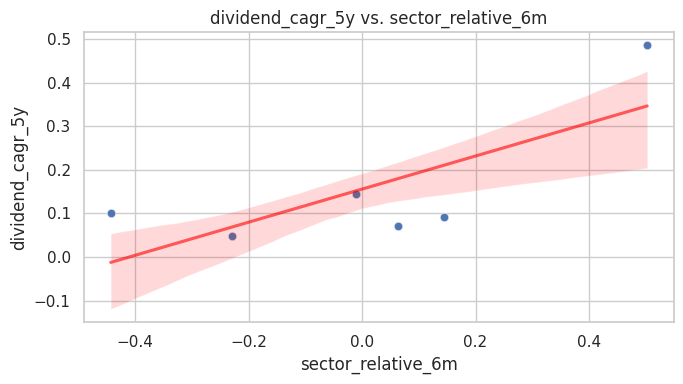

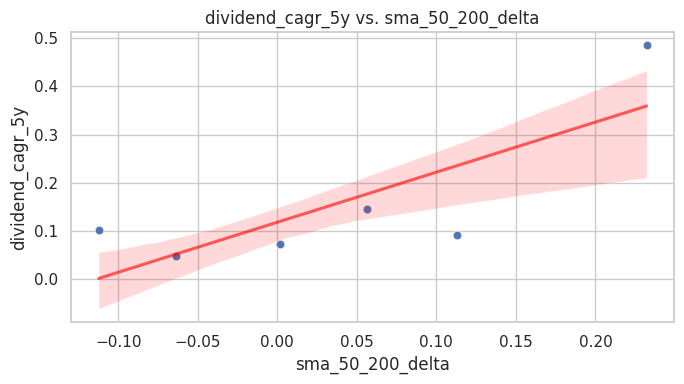

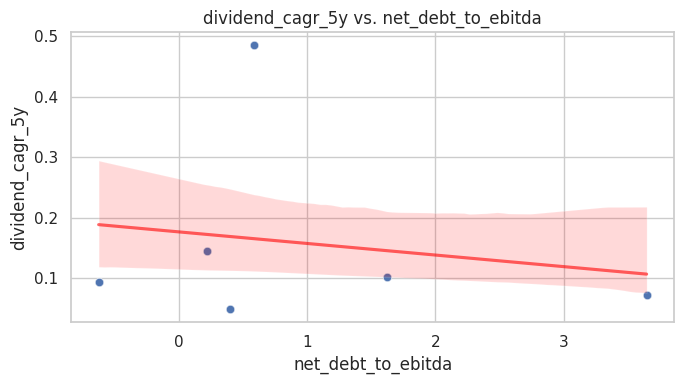

/workspaces/codespaces-blank/dvmax/.venv/lib/python3.12/site-packages/numpy/_core/function_base.py:162: RuntimeWarning: invalid value encountered in multiply
  y *= step
/workspaces/codespaces-blank/dvmax/.venv/lib/python3.12/site-packages/seaborn/regression.py:255: RuntimeWarning: invalid value encountered in dot
  yhat_boots = grid.dot(beta_boots).T
/workspaces/codespaces-blank/dvmax/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/workspaces/codespaces-blank/dvmax/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


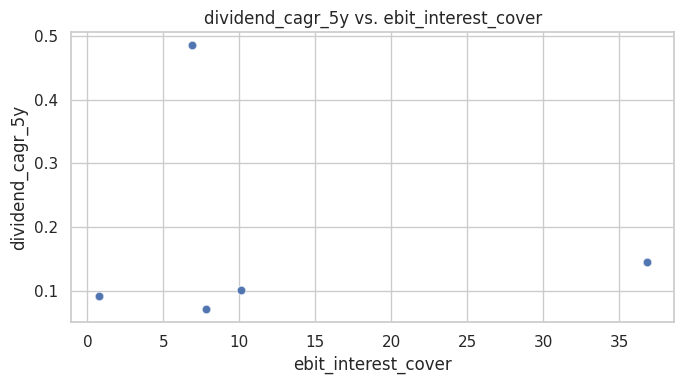

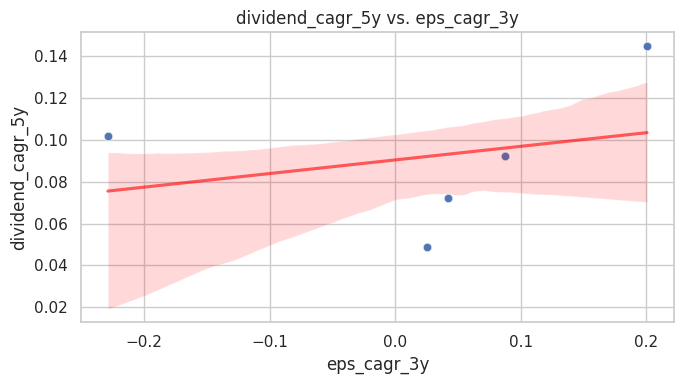

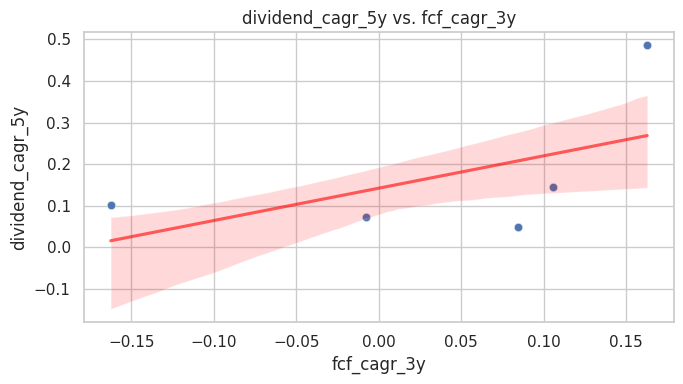

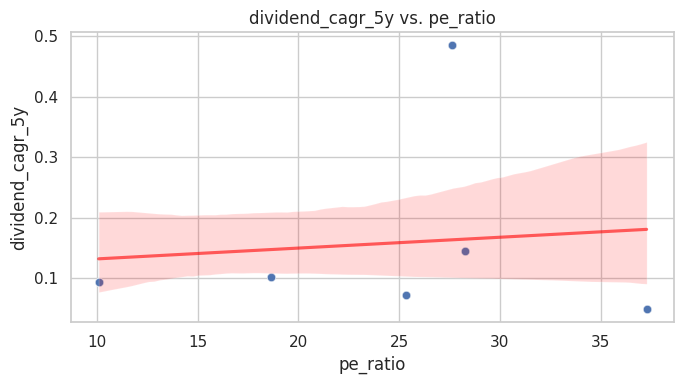

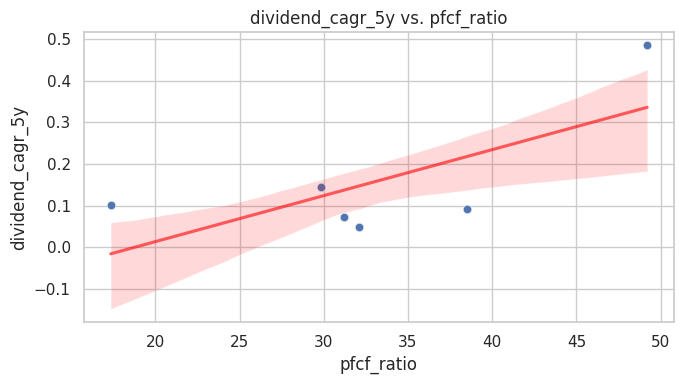

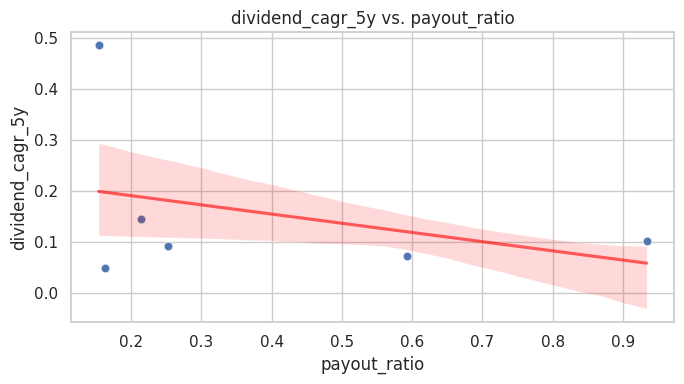

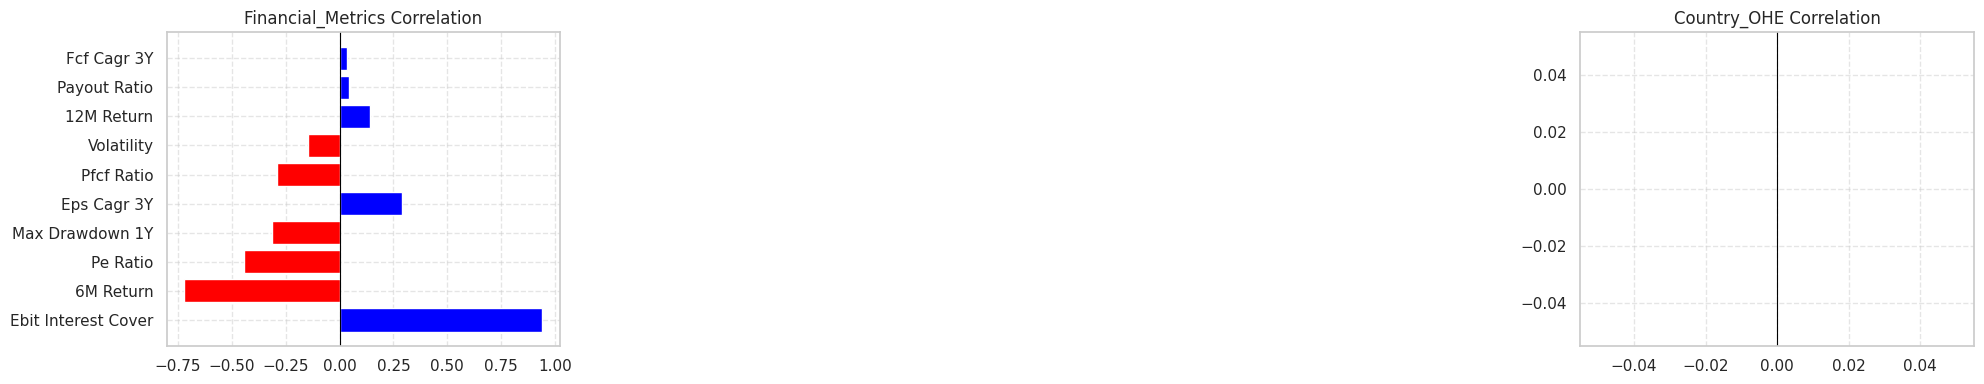

Not enough data for modeling.


Analyzing feature: yield_vs_5y_median
⚠️ ebit_interest_cover_capped is bool instead of numeric

🔍 Analyzing: yield_vs_5y_median


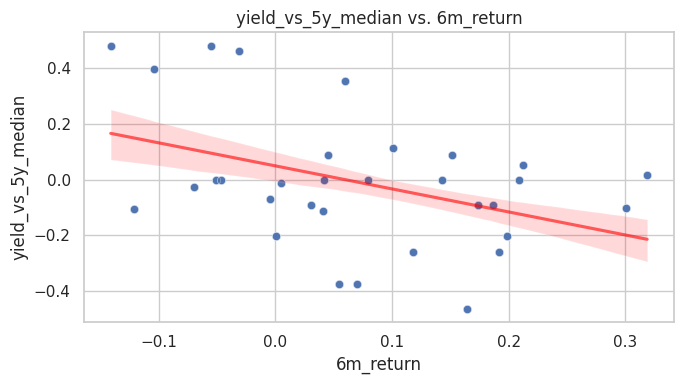

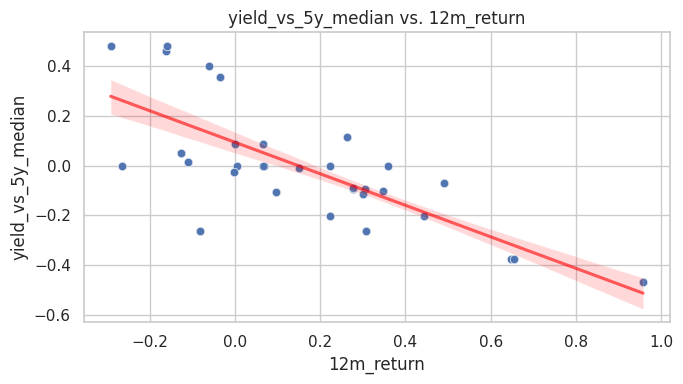

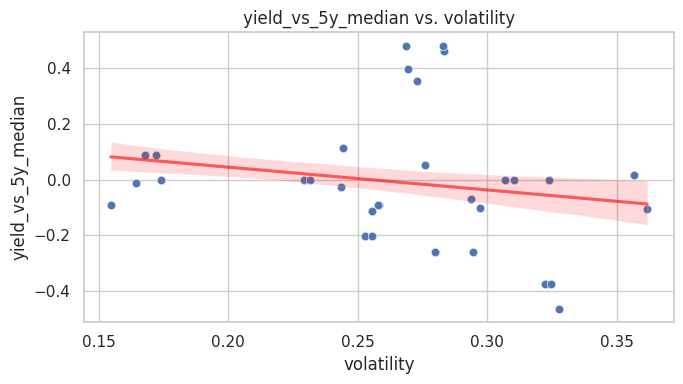

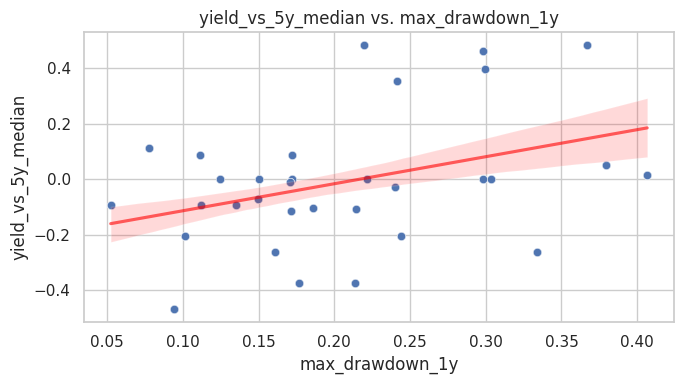

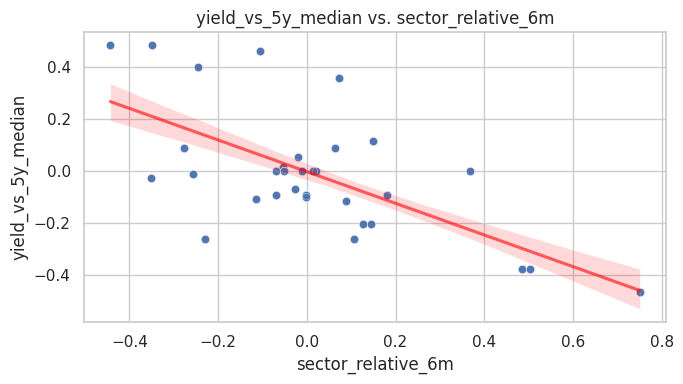

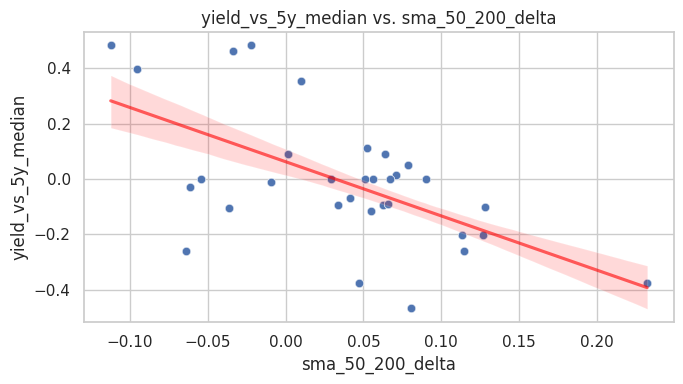

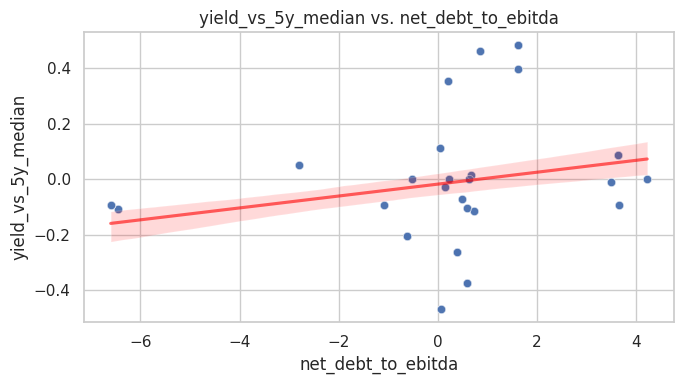

/workspaces/codespaces-blank/dvmax/.venv/lib/python3.12/site-packages/numpy/_core/function_base.py:162: RuntimeWarning: invalid value encountered in multiply
  y *= step
/workspaces/codespaces-blank/dvmax/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/workspaces/codespaces-blank/dvmax/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


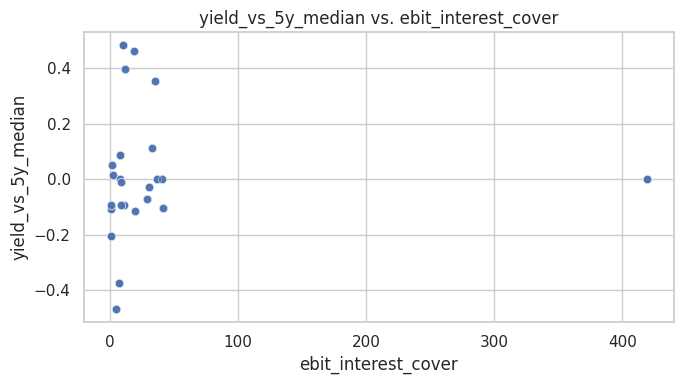

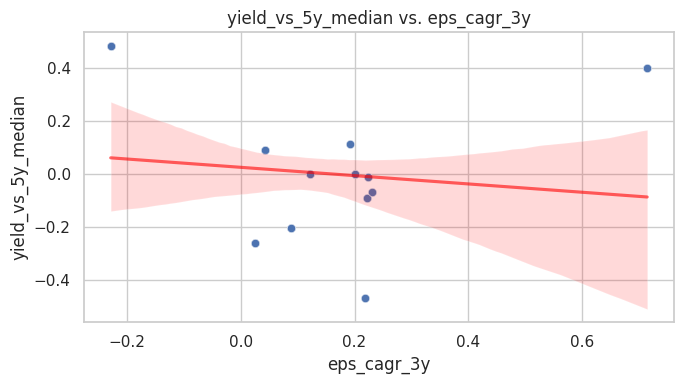

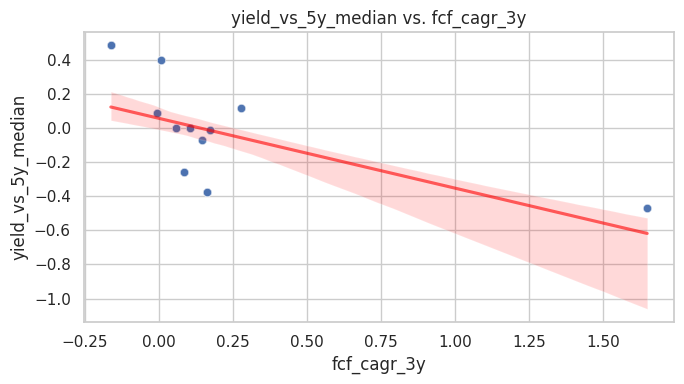

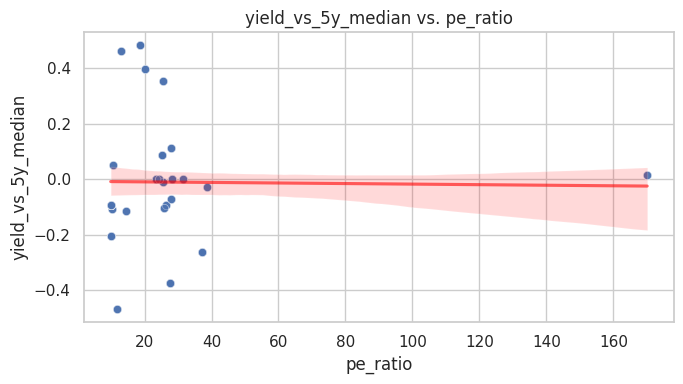

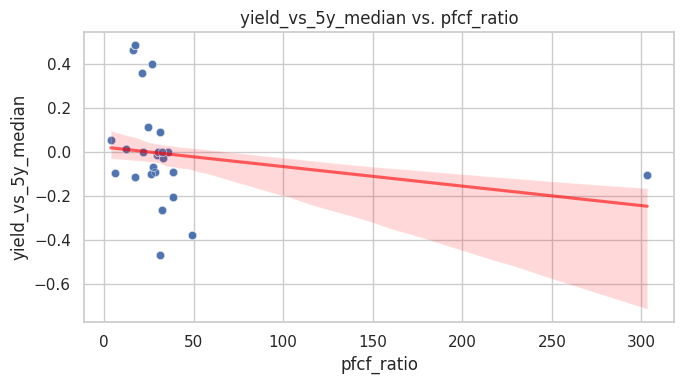

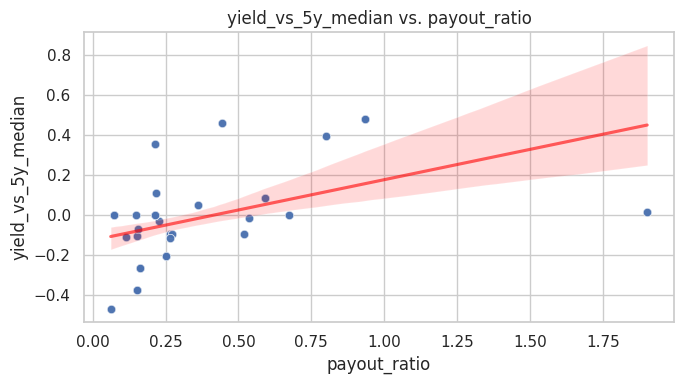

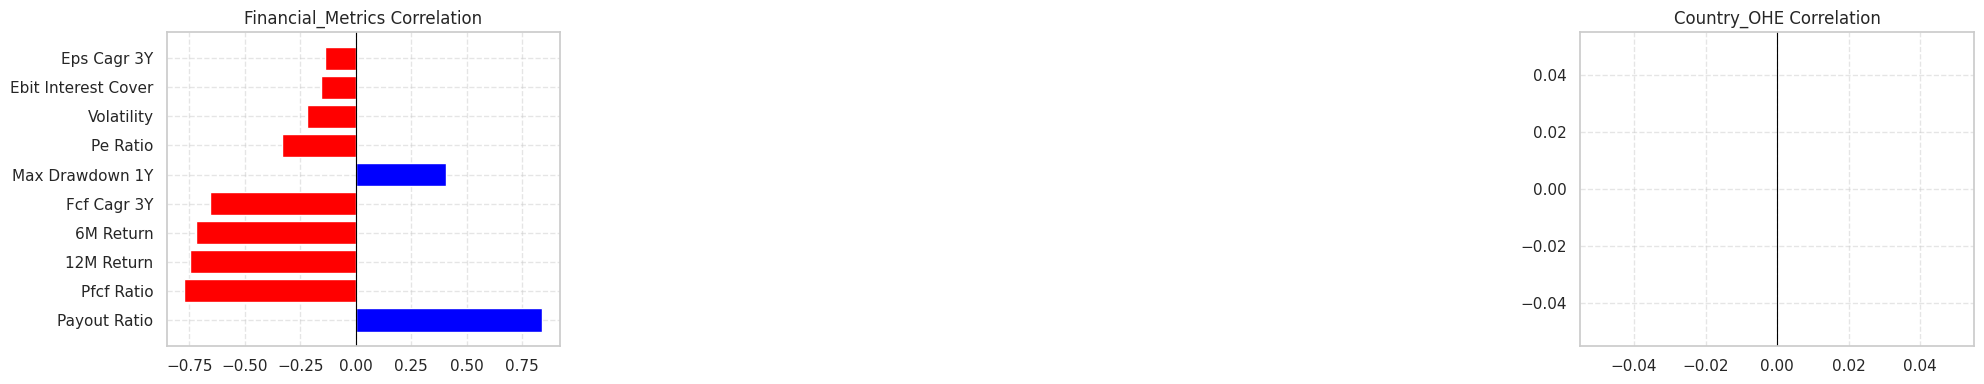

Not enough data for modeling.


In [15]:
for target in DIVIDEND_FEATURES:
    print (f"\n\n{'=' * 40}\nAnalyzing feature: {target}\n{'=' * 40}")
    analyze_feature_impact(target)


In [ ]:
# for target in DIVIDEND_FEATURES:
#     analyze_feature_impact(target)

### 🔥 Partial Correlation Heatmap using valid features only
🔍 What this does:
- Computes pairwise correlations.
- Selects only features with at least one absolute correlation ≥ 0.3 to a dividend feature.
- Shows a cleaner, interpretable heatmap using clustermap (which groups similar variables).

In [ ]:
correlation_features = DIVIDEND_FEATURES + numerical_independent_features
valid_corr_features = [
    col for col in correlation_features
    if col in df_merged.columns and df_merged[col].dtype in ['float64', 'float32', 'int64']
]

# Keep only columns with ≥5 non-NaN values
valid_counts = df_merged[valid_corr_features].notna().sum()
selected_features = valid_counts[valid_counts >= 5].index.tolist()

# Configuration
target_features = DIVIDEND_FEATURES
threshold = 0.3  # Adjust this threshold as needed

# Compute correlation matrix
corr_matrix = df_merged[selected_features].corr()

# Identify features with at least one strong correlation with any dividend feature
strong_corrs = corr_matrix[target_features].abs().max(axis=1)
filtered_features = strong_corrs[strong_corrs >= threshold].index.tolist()

# If nothing is found, fallback to a warning
if len(filtered_features) < 2:
    print(f"⚠️ No features found with |correlation| ≥ {threshold} to any dividend feature.")
else:
    # Compute filtered correlation matrix
    filtered_corr = df_merged[filtered_features].corr()

    # Optional: cluster to improve interpretability
    try:
        import seaborn as sns
        import matplotlib.pyplot as plt

        sns.clustermap(
            filtered_corr,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            center=0,
            linewidths=0.5,
            figsize=(12, 10)
        )
        plt.title(f"Filtered Correlation Heatmap (|r| ≥ {threshold})", pad=80)
        plt.show()
    except Exception as e:
        print(f"⚠️ Failed to render heatmap: {e}")

### 📌 **Top Insights on Dividend Features**

#### 1. **Dividend Yield**

* Strong **positive correlation** with:

  * `payout_ratio` (r ≈ 0.73)
  * `net_debt_to_ebitda` (r ≈ 0.57)
* Strong **negative correlation** with:

  * `sma_50_200_delta`, `fcf_cagr_3y`, and `volatility` (r ≈ -0.5 to -0.6)

🧠 *Interpretation*: High dividend yield tends to occur in **financially mature, lower-growth stocks** with higher debt and slower momentum.

---

#### 2. **Dividend CAGR (3Y, 5Y)**

* Strong **positive correlation** with:

  * `fcf_cagr_3y`, `eps_cagr_3y` (r ≈ 0.8+)
  * `sma_50_200_delta`, `6m_return`, `12m_return` (r ≈ 0.5–0.8)

🧠 *Interpretation*: Sustained dividend growth is **highly aligned with earnings and cash flow growth**, and coincides with **positive price momentum**.

---

#### 3. **Yield vs. 5Y Median**

* Strong **negative correlation** with:

  * `fcf_cagr_3y`, `dividend_cagr_5y`, `sma_50_200_delta` (r ≈ -0.5 to -0.8)

🧠 *Interpretation*: When dividend growth and performance are high, yields tend to be **compressed vs. historical median**, likely due to price appreciation.

---

### 💥 Additional Highlights

* `fcf_cagr_3y` and `eps_cagr_3y` are **core growth drivers**, highly correlated with most dividend-growth indicators.
* `sector_relative_6m` and `sma_50_200_delta` are also informative of dividend trends, linking **technical momentum** to dividend behaviors.
* `net_debt_to_ebitda` shows up as a red flag for **high yield but low growth**, supporting a “value trap” narrative in some cases.

---

### 🔚 Summary

* **Yield**: linked to **debt, payout, and negative momentum**.
* **Growth**: driven by **fundamentals (FCF, EPS)** and **positive technicals**.
* **Over-yielding**: may signal **underperformance or risk**, not opportunity.